In [3]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression

In [4]:
conf = (SparkConf()
            .setAppName('data_explore')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "200")
conf.set("spark.default.parallelism", "3")
conf.set("spark.driver.memory", "3g") 

## TODO
+ test final model against this dataset: https://github.com/hunters-forge/mordor

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [6]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '42215'),
 ('spark.app.id', 'app-20191109012245-0026'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', '7b97f6eeabc6'),
 ('spark.driver.memory', '3g'),
 ('spark.default.parallelism', '3'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.sql.shuffle.partitions', '200'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'data_explore')]

In [7]:
df = (spark.read.format('csv')
      .option('inferSchema', 'false')
      .option('header', 'true')
      .option('escape', '"')
      .option('schema', T.StringType())
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() # orginal dataset had 52,025 rows, this operation drops 682 rows
     )

## the target labels are unbalanced, and will result in a model with high variance.  the minority class (1) will be resampled

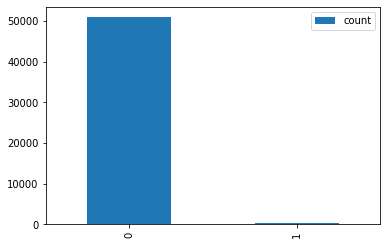

In [8]:
df.groupBy('class_label').count().toPandas().plot.bar()

In [9]:
df.groupBy('class_label').count().show()

+-----------+-----+
|class_label|count|
+-----------+-----+
|          0|50891|
|          1|  452|
+-----------+-----+



In [10]:
bootstrapped_1_rdd = spark.sparkContext.union([df.filter('class_label == 1').sample(withReplacement=True, fraction=.1, seed=0).rdd
                  for x in range(1000)])
bootstrapped_1_df = spark.createDataFrame(bootstrapped_1_rdd)

In [11]:
%%time
bootstrapped_1_df.count()

CPU times: user 181 ms, sys: 78.7 ms, total: 260 ms
Wall time: 3min 20s


47000

In [12]:
bootstrapped_1_df.show()

+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------+--------+--------------------+-----------+
|           timestamp|       hostname|              kernel|host_platform|        process_name|      parent_process|login_id|event_id|        command_line|class_label|
+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------+--------+--------------------+-----------+
|2019-11-03T12:38:...|    win10-alice|10.0.17763.802 (W...|      windows|C:\Windows\System...|C:\Users\Public\s...|     0x0|    4688|powershell.exe -E...|          1|
|2019-11-03T12:40:...|    win10-alice|10.0.17763.802 (W...|      windows|C:\Windows\System...|C:\Users\Public\s...|     0x0|    4688|   cmd.exe /C whoami|          1|
|2019-11-03T12:40:...|DESKTOP-1P21UNK|10.0.18362.449 (W...|      windows|C:\Windows\System...|C:\Users\Public\s...|     0x0|    4688|powershell.exe -E...|          1

In [13]:
combined_df = spark.createDataFrame(spark.sparkContext.union([bootstrapped_1_df.rdd, df.rdd]))
combined_df.cache()

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: string, command_line: string, class_label: string]

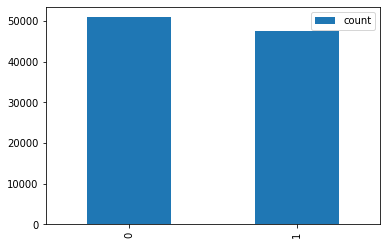

In [14]:
combined_df.groupBy('class_label').count().toPandas().plot.bar()

## clean process,path fields and create command line tokens

In [9]:
# TODO: consider converting this to a UDF

from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date
clean_df = df.select(
    '*',
    regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    split(col('command_line'), '\s+(?=[-/]+)').alias('cmd_line_split')
).withColumn(
    'class_label', (col('class_label').cast('int'))
).withColumn(
    'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like('%Program Files (x86)%')).cast('int')
).withColumn(
    '_timestamp', F.to_timestamp(col('timestamp'))
).withColumn(
    'process_name', regexp_extract(col('process_name'), r'(\w+.?\w+$)', 0)
).withColumn(
    'parent_process', regexp_extract(col('parent_process'), r'(\w+.?\w+$)', 0)
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[:\\"\?]'," ")  # directory punct
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'--field-trial-handle=.*\d+',"")   # chrome data
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\/\/raw.*\.com(\/\w+)*.*\/',"") # github url
).withColumn(
    'command_line', regexp_replace(col('command_line'), r"\||\s*\"\s*\|\"|-\s*\d{1}\s*|\'","")  # | " 1 ' , 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r':\/\/(\d+\.?)+:\d+',"")  # ip 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\b\d+\b',"")  # lone numbers
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\{.*\}',"")  # {edfc6dbe, 9c3, 3ed, 21a1affb5fd}
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[=/;\(\),_]',"") # random punctuation
).withColumn(
    'cmd_line_tokens', split(col('command_line'), '\s+')
)

## cleaned command line tokens

In [16]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def clean_array(l):
    arr = [str(x).lower() for x in l if x != 'C' and x != ""]
    return arr

In [17]:
clean_df = clean_df.withColumn('cmd_line_tokens', clean_array(col('cmd_line_tokens')))

In [18]:
clean_df.select('cmd_line_tokens').sample(.10).show(20, False)
clean_df.cache()

+------------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                           |
+------------------------------------------------------------------------------------------+
|[windows, system32, upfc.exe, launchtype, boot, cv, 09o3cnnaskg8amtnuwkqhq.]              |
|[windows, system32, svchost.exe, -k, netsvcs, -p, -s, gpsvc]                              |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p]                   |
|[windows, system32, svchost.exe, -k, netsvcs, -p, -s, dmwappushservice]                   |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p, -s, smsrouter]    |
|[windows, system32, svchost.exe, -k, networkservice, -p, -s, nlasvc]                      |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p, -s, timebrokersvc]|
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: string, command_line: string, class_label: int, process_path: string, cmd_line_split: array<string>, trusted_path: int, _timestamp: timestamp, cmd_line_tokens: array<string>]

## create freq and tfidf pipeline

sc = spark.sparkContext
broadcast_clean_df = sc.broadcast(clean_df)

In [19]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(clean_df)

In [20]:
cv_pipeline.transform(clean_df).select('tf').show(20,truncate=False)

+------------------------------------------------------------------+
|tf                                                                |
+------------------------------------------------------------------+
|(1305,[7,8,25,26,55,249],[1.0,1.0,1.0,1.0,1.0,1.0])               |
|(1305,[7,8,25,26,55,56,101,477],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(1305,[648,1112],[1.0,1.0])                                       |
|(1305,[7,8,648,829],[1.0,1.0,1.0,1.0])                            |
|(1305,[7,8,25,26,55,56,94,370],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(1305,[7,8,25,26,55,56,98,464],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(1305,[7,8,25,26,55,56,94,458],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(1305,[7,8,311,355,360,401],[1.0,1.0,1.0,1.0,1.0,1.0])            |
|(1305,[7,8,25,26,56,98,424],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])        |
|(1305,[7,8,25,26,55,56,94,507],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]) |
|(1305,[7,8,25,26,55,56,101,478],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(1305,[7,8,25,26,55,56,69,161],[1

In [21]:
len(cv_pipeline.stages[0].vocabulary)

1305

In [22]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(clean_df)

In [23]:
tfidf_df = idf_pipeline.transform(clean_df)

## create logistic regression model

In [24]:
training_df, validation_df, testing_df = clean_df.select('cmd_line_tokens', 'class_label').randomSplit([0.6, 0.3, 0.1], seed=0)

In [25]:
[training_df.count(), validation_df.count(), testing_df.count()]

[30843, 15310, 5190]

In [26]:
lr = LogisticRegression(featuresCol='tfidf', labelCol='class_label')

In [27]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    lr
]).fit(training_df)

In [28]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+------------+
|avg(correct)|
+------------+
|         1.0|
+------------+



In [29]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

## the positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [30]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
860,reg,25.696877
350,wmic,12.354456
1255,calc,8.809769
149,cmd.exe,5.625244
97,-executionpolicy,4.371764
96,bypass,4.371764
90,-c,3.374369
382,regsvr32.sct,2.891952
378,u,2.891952
380,i,2.891952


## example of malicious tokens

In [31]:
training_df.select('cmd_line_tokens').filter('class_label == 1').sample(.20).show(15, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                                                                                                                                                                                                                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------

## the negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [32]:
coeffs_df.sort_values('weight').head(20)

,token,weight
878,reg.exe,-47.126464
2,program,-17.335210
3,files,-17.304727
7,windows,-16.944267
8,system32,-16.860308
4,x86,-16.380919
5,application,-15.847114
6,chrome.exe,-15.830066
353,wmic.exe,-13.476653
80,taskhostw.exe,-5.597604


## example of benign tokens

In [33]:
training_df.select('cmd_line_tokens').filter('class_label == 0').sample(.20).show(5, truncate=False)

+--------------------------------------------------------------------------------+
|cmd_line_tokens                                                                 |
+--------------------------------------------------------------------------------+
|[%systemroot%, system32, musnotificationux.exe, clearactivenotifications]       |
|[%systemroot%, system32, musnotificationux.exe, dialogrebootactivehoursimminent]|
|[%systemroot%, system32, musnotifyicon.exe, notifytrayicon]                     |
|[%systemroot%, system32, musnotifyicon.exe, notifytrayicon]                     |
|[%systemroot%, system32, musnotifyicon.exe, notifytrayicon]                     |
+--------------------------------------------------------------------------------+
only showing top 5 rows



## create another model with elastic net regularization to control overfitting and mitigate noisy data

In [34]:
en_lr = Pipeline(stages=[
    idf_pipeline,
    LogisticRegression(featuresCol='tfidf',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
]).fit(training_df)

In [35]:
validation_model = en_lr.transform(validation_df)

In [36]:
from pyspark.sql.functions import avg
validation_model.selectExpr('avg(float(prediction = class_label)) as prediction').show()

+------------------+
|        prediction|
+------------------+
|0.9998693664271718|
+------------------+



## re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [37]:
coefs = en_lr.stages[-1].coefficients.toArray()
word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weights': coefs})

+ malicious tokens

In [38]:
word_coefs.sort_values('weights', ascending=False).head(15)

,token,weights
149,cmd.exe,0.957036
97,-executionpolicy,0.594190
96,bypass,0.594190
90,-c,0.463404
168,net,0.265239
378,u,0.245570
380,i,0.245570
386,scrobj.dll,0.245570
382,regsvr32.sct,0.245570
195,whoami,0.153714


+ benign tokens

In [39]:
word_coefs.sort_values('weights', ascending=True).head(10)

,token,weights
0,google,0.0
873,invagent.dll,0.0
872,get-service,0.0
871,securityhealthhost.exe,0.0
870,copy-item,0.0
869,runupdate,0.0
868,stopped,0.0
867,pending.xml,0.0
874,noreboot,0.0
866,runonbattery,0.0


+ The 'C' is the directory path for all programs, not very informative here and should probably be removed 
+ The random numbers look to be from Microsoft Edge browser url srings, and other seemingly benign system processes--however hackers use similar encoding strategies for malicious code execution; therefore this feature shouldn't be ignored

In [40]:
new_testing_df = testing_df.select('cmd_line_tokens')
new_testing_df.show()

+--------------------+
|     cmd_line_tokens|
+--------------------+
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[%systemroot%, sy...|
|[backgroundtransf...|
|       [consent.exe]|
|[consent.exe, 000...|
|[consent.exe, 000...|
|[consent.exe, 000...|
|[consent.exe, 000...|
|[consent.exe, 000...|
|        [ctfmon.exe]|
|        [ctfmon.exe]|
|           [dwm.exe]|
|           [dwm.exe]|
+--------------------+
only showing top 20 rows



In [41]:
test_model = en_lr.transform(new_testing_df).show()
# test_model.selectExpr('avg(float(prediction = class_label)) as prediction').show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     cmd_line_tokens|                  tf|               tfidf|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|[%systemroot%, sy...|(1305,[8,151,322,...|(1305,[8,151,322,...|[6.44726605546488...|[0.99841765863152...|       0.0|
|[%systemroot%, sy...|(1305,[8,151,175,...|(1305,[8,151,175,...|[6.44726605546488...|[0.99841765863152...|       0.0|
|[%systemroot%, sy...|(1305,[8,151,175,...|(1305,[8,151,175,...|[6.44726605546488...|[0.99841765863152...|       0.0|
|[%systemroot%, sy...|(1305,[8,151,175,...|(1305,[8,151,175,...|[6.44726605546488...|[0.99841765863152...|       0.0|
|[%systemroot%, sy...|(1305,[8,151,175,...|(1305,[8,151,175,...|[6.44726605546488...|[0.99841765863152...|       0.0|
|[%systemroot%, sy...|(1305,[8,151,175,...|(1305,[8,151,

## write LR intecept, coefficients, and CV vocabulary to disk

In [42]:
en_lr.stages[1].intercept

-6.447266055464887

In [43]:
import pickle

with open('coefs_array.pkl', 'wb') as f:
    pickle.dump(coefs, f)
with open('intercept.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[1].intercept, f)
with open('cv_vocabulary.pkl', 'wb') as f:
    pickle.dump(en_lr.stages[0].stages[0].stages[0].vocabulary, f)